In [1]:
# https://www.tensorflow.org/tutorials/text/word_embeddings

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [13]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True, as_supervised=True)

Shuffling and writing examples to C:\Users\Dev\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteDLU0X3\imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\Users\Dev\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteDLU0X3\imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\Users\Dev\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteDLU0X3\imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\Dev\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [4]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [5]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [6]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[1342,   91,  119, ...,   13,  203, 7975],
       [  12,  258,    4, ...,    0,    0,    0],
       [  62,    9,  281, ...,    0,    0,    0],
       ...,
       [ 173,    9,  195, ...,    0,    0,    0],
       [  62,   27,   18, ...,    0,    0,    0],
       [6001, 7961,    7, ...,    0,    0,    0]], dtype=int64)

In [7]:
embedding_dim=16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches,
    validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4958 - accuracy: 0.7061 - val_loss: 0.3197 - val_accuracy: 0.8700
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2787 - accuracy: 0.8858 - val_loss: 0.3237 - val_accuracy: 0.8800
Epoch 3/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2271 - accuracy: 0.9115 - val_loss: 0.3741 - val_accuracy: 0.8550
Epoch 4/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1949 - accuracy: 0.9262 - val_loss: 0.3030 - val_accuracy: 0.8500
Epoch 5/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1739 - accuracy: 0.9359 - val_loss: 0.4328 - val_accuracy: 0.8500
Epoch 6/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.1564 - accuracy: 0.9420 - val_loss: 0.3472 - val_accuracy: 0.8500
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.1383 - accuracy: 0.9502 - val_loss: 0.3695 - val_accuracy

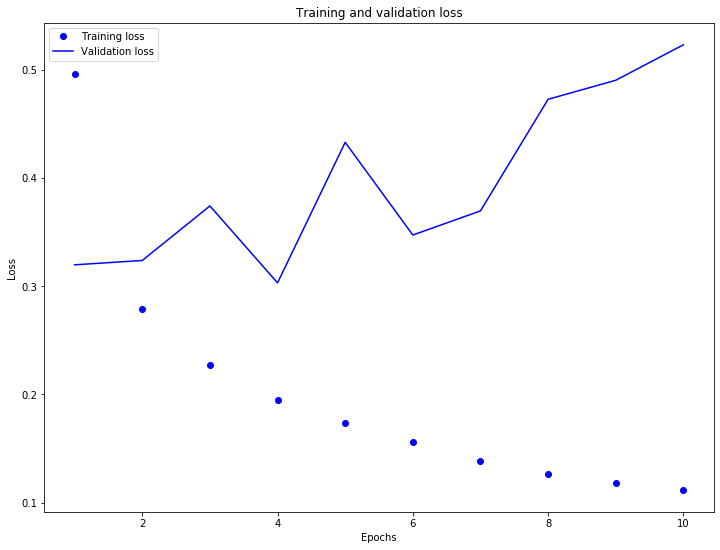

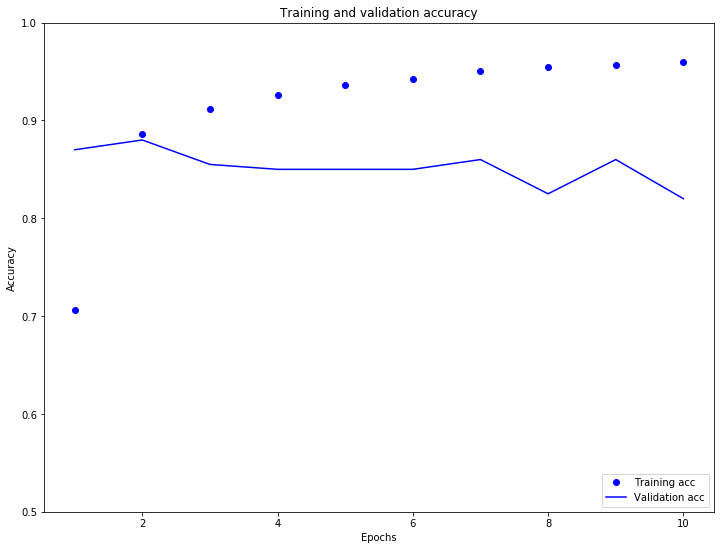

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [10]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [11]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()
